# P000456CSITCP - Hate Speech Detection

*This will be a summary of the entire jupyternotebook* I will do this at the end :)

In [73]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Loading The Dataset 

- The twitter.csv file is loaded into the variable name data. This is then used to condut initial analysis onthe data.
- The variables on this csv file are unamed, count, hate_speech, offensive_language, neither and class. 

Below is a list explaining each variable 
- count: The total number of annotations for each tweet. (Integer) </br>
- hate_speech: The number of annotations classifying a tweet as hate speech. (Integer)</br>
- offensive_language_count: The number of annotations classifying a tweet as offensive language. (Integer)</br>
- neither_count: The number of annotations classifying a tweet as neither hate speech nor offensive language. (Integer)</br>
- class: The level of hate in which the twitter comment is projecting; hate speech, offensive language or neither. (Integer) </br>
- tweet: The tweet which the classfications are being made (String) </br>

NOTE: The Unnamed column looks to be an index column.

In [144]:
# Load the data
data = pd.read_csv('twitter.csv')

# Display the first 5 rows of the data
print(data.head())


   Unnamed: 0  count  hate_speech  offensive_language  neither  class   
0           0      3            0                   0        3      2  \
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                                                                                                                          tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...  
1                                                         !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!  
2                      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You

In [145]:
data['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

To really understand the level of hate in which the dataset entials the class variable in looked into further. It can be said that 'class' 1 has the most counts followed by 'class' 2 then 3. 

The class column indicates 
- 0: Hate Speech 
- 1: Offensive Language
- 2: Neither 

In [146]:
data.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


Looking at the statistical analysis of each variable (excluding count and unamed) it can be said that:

- hate_speech: With a mean of 0.28 it can be said that most entries have low levels of hate_speech and thus most likely not being classified as hate speech. Aditionally with a 0.0 distibrution for the 25, 50 and 75 percentile show no hate speech in the data points. With a max of 7 it can highlight some entires of high levels of hate speech 

- offesnive_language: A mean of 2.41 shows a higher average than hate_speech and can therefore be said that offensive language is more common than hate speech. It can be noted that half of the data had a score of 3 or lower for offensive langauge. Some entires also show high levels of offensive language with a max value of 9. 

- neither: The mean od 0.55 shows a good portion of the data is neither hate speech or offensive language. Aditionally with a 0.0 distibrution for the 25, 50 and 75 percentile show that the data falls into other categories. Some entires also show high levels of neither category with a max value of 9. 

- class: 1.11 mean shows most enties are classified as offensive langauge (1). This can be shown with the 25th and 50th percentiles being 1. The max value of 2 shows that hate speech is present but less common. 

Ultimately the data is skewed towards offensive language. A larger proportion of the data can be seen to be offensive language as seen by the class in comparison to hate speech and a small group within neither.

In [147]:
data.isna().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [148]:
data.duplicated().sum()

0

It can also be seen that there are no n/a data within any of the variables and no duplicated data in the dataset as well. 

<Axes: xlabel='class', ylabel='Count'>

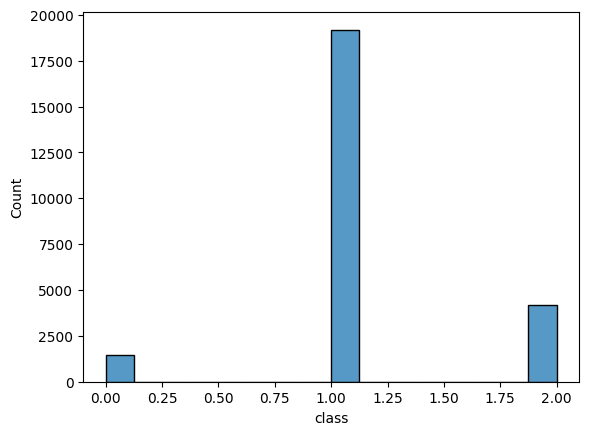

In [149]:
# plot the distribution of the classes
sns.histplot(data['class'])


Looking at the histogram it can be reinstated that the offensive langauge category is classfied heavily in the dataset followed by approximately 25% of the data classfied as neither and hate speech.

## Data Processing

- The data preprocessing stage is important to turn the raw data (twitter.csv) into clean data that can then be used for training and testing. 

The next steps that must be taken after the intial data analysis is data preprocessing. Here the dataset is taken and the following elements are removed from the dataset: 

- urls
- usernames (especially for anonymity)
- emojis
- punctuation
- single characters + double spaces

The following are processed to ensure clarity in the data:

- Turning everything lowercase

In [150]:
data_processed=data[['tweet','class']]
data_processed.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,1


In [151]:
# remove the urls
data_processed["tweet"] = data_processed["tweet"].apply(lambda x:re.sub(r'https?://\S+', '', str(x)))
data_processed["tweet"]


C:\Users\Admin\AppData\Local\Temp\ipykernel_13592\2544297350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed["tweet"] = data_processed["tweet"].apply(lambda x:re.sub(r'https?://\S+', '', str(x)))


0              !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1                                                                     !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2                                  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3                                                                                            !!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4                 !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
                                                                                ...                                                                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls 

In [152]:
# Lowercase removal
data_processed['tweet'] = data_processed['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data_processed['tweet']

C:\Users\Admin\AppData\Local\Temp\ipykernel_13592\1831671013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))


0              !!! rt @mayasolovely: as a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1                                                                     !!!!! rt @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2                                  !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby4life: you ever fuck a bitch and she start to cry? you be confused as shit
3                                                                                            !!!!!!!!! rt @c_g_anderson: @viva_based she look like a tranny
4                 !!!!!!!!!!!!! rt @shenikaroberts: the shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
                                                                                ...                                                                        
24778    you's a muthaf***in lie &#8220;@lifeasking: @20_pearls 

In [153]:
# Punctuation Removal
data_processed['tweet'] = data_processed['tweet'].str.replace('[^\w\s]','')
data_processed['tweet']

C:\Users\Admin\AppData\Local\Temp\ipykernel_13592\2353336898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].str.replace('[^\w\s]','')


0              !!! rt @mayasolovely: as a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1                                                                     !!!!! rt @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2                                  !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby4life: you ever fuck a bitch and she start to cry? you be confused as shit
3                                                                                            !!!!!!!!! rt @c_g_anderson: @viva_based she look like a tranny
4                 !!!!!!!!!!!!! rt @shenikaroberts: the shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
                                                                                ...                                                                        
24778    you's a muthaf***in lie &#8220;@lifeasking: @20_pearls 

In [154]:
# Single character and double space removal (a/i/n etc)
data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))
data_processed['tweet'] 

C:\Users\Admin\AppData\Local\Temp\ipykernel_13592\3867049835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))


0                !!! rt @mayasolovely: as woman you shouldn't complain about cleaning up your house. &amp; as man you should always take the trash out...
1                                                                   !!!!! rt @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2                                  !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby4life: you ever fuck bitch and she start to cry? you be confused as shit
3                                                                                            !!!!!!!!! rt @c_g_anderson: @viva_based she look like tranny
4               !!!!!!!!!!!!! rt @shenikaroberts: the shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
                                                                               ...                                                                       
24778    you's muthaf***in lie &#8220;@lifeasking: @20_pearls @corey_emanuel

In [155]:
# remove usernames/handles 
data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'@\w+', '', x))
data_processed['tweet']

C:\Users\Admin\AppData\Local\Temp\ipykernel_13592\3113575936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'@\w+', '', x))


0        !!! rt : as woman you shouldn't complain about cleaning up your house. &amp; as man you should always take the trash out...
1                                                      !!!!! rt : boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2                                        !!!!!!! rt  dawg!!!! rt : you ever fuck bitch and she start to cry? you be confused as shit
3                                                                                               !!!!!!!!! rt :  she look like tranny
4         !!!!!!!!!!!!! rt : the shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
                                                                    ...                                                             
24778                  you's muthaf***in lie &#8220;:   right! his tl is trash &#8230;. now, mine? bible scriptures and hymns&#8221;
24779                                                         you've 

In [156]:
# remove emojis
data_processed['tweet'] = data_processed['tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
data_processed['tweet']

C:\Users\Admin\AppData\Local\Temp\ipykernel_13592\643837315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))


0        !!! rt : as woman you shouldn't complain about cleaning up your house. &amp; as man you should always take the trash out...
1                                                      !!!!! rt : boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2                                        !!!!!!! rt  dawg!!!! rt : you ever fuck bitch and she start to cry? you be confused as shit
3                                                                                               !!!!!!!!! rt :  she look like tranny
4         !!!!!!!!!!!!! rt : the shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
                                                                    ...                                                             
24778                  you's muthaf***in lie &#8220;:   right! his tl is trash &#8230;. now, mine? bible scriptures and hymns&#8221;
24779                                                         you've 

After removing emojis, usernames/handles, single charters, double spaces, punctuations, lowercases and URLs, the most common words are generated to understand what is the most common words amongst tweets. 

In [157]:
# Most common words
freq = pd.Series(' '.join(data_processed['tweet']).split()).value_counts()[:10]
freq


rt       7569
:        7399
the      7136
bitch    6750
you      5673
to       5296
and      3932
my       3543
that     3397
in       3003
Name: count, dtype: int64

It can be noted that the words/symbols 'rt' and ':' are the most common among the tweets. These two words/symbols are of no benefit for this dataset and do not contribute to the analysis of hate speech. The term 'rt' is used in twitter to say retweet which is the action of re posting a twitter post and the semicolon, :, can be used for gramatical purposes. 

For this analysis, "rt" and the ":" symbol are not needed, so we can remove them as well. 

In [158]:
# remove the words rt and :
data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'rt', '', x))
data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r':', '', x))
data_processed['tweet']

C:\Users\Admin\AppData\Local\Temp\ipykernel_13592\48207569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'rt', '', x))
C:\Users\Admin\AppData\Local\Temp\ipykernel_13592\48207569.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r':', '', x))


0        !!!   as woman you shouldn't complain about cleaning up your house. &amp; as man you should always take the trash out...
1                                                      !!!!!   boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2                                            !!!!!!!   dawg!!!!   you ever fuck bitch and she sta to cry? you be confused as shit
3                                                                                               !!!!!!!!!    she look like tranny
4         !!!!!!!!!!!!!   the shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
                                                                   ...                                                           
24778                you's muthaf***in lie &#8220;   right! his tl is trash &#8230;. now, mine? bible scriptures and hymns&#8221;
24779                                                        you've gone and broke the wro

In [159]:
# show the most common words
freq = pd.Series(' '.join(data_processed['tweet']).split()).value_counts()[:10]
freq

the        7136
bitch      6755
you        5677
to         5298
and        3932
my         3543
that       3398
in         3005
is         2854
bitches    2681
Name: count, dtype: int64

Looking at the most common words the list only displays words however there are still special characters in the data which will interfere with the analysis, so we can remove those. 

In [160]:
# remove special and numeric characters
data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'[^a-zA-Z\s]', '', x))
data_processed['tweet']

C:\Users\Admin\AppData\Local\Temp\ipykernel_13592\4181547221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'[^a-zA-Z\s]', '', x))


0           as woman you shouldnt complain about cleaning up your house amp as man you should always take the trash out
1                                                          boy dats coldtyga dwn bad for cuffin dat hoe in the st place
2                                                 dawg   you ever fuck bitch and she sta to cry you be confused as shit
3                                                                                                  she look like tranny
4                       the shit you hear about me might be true or it might be faker than the bitch who told it to ya 
                                                              ...                                                      
24778                                   yous muthafin lie    right his tl is trash  now mine bible scriptures and hymns
24779                                                youve gone and broke the wrong hea baby and drove me redneck crazy
24780                                   

In [161]:
# remove any double spaces
data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))
data_processed['tweet']

C:\Users\Admin\AppData\Local\Temp\ipykernel_13592\689008908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))


0         as woman you shouldnt complain about cleaning up your house amp as man you should always take the trash out
1                                                        boy dats coldtyga dwn bad for cuffin dat hoe in the st place
2                                                 dawg you ever fuck bitch and she sta to cry you be confused as shit
3                                                                                                she look like tranny
4                     the shit you hear about me might be true or it might be faker than the bitch who told it to ya 
                                                             ...                                                     
24778                                     yous muthafin lie right his tl is trash now mine bible scriptures and hymns
24779                                              youve gone and broke the wrong hea baby and drove me redneck crazy
24780                                                   

In [162]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Additionally stopwords can be removed to only display keywords which may be curcial in identifying hate speech, offensive langauge tweets in datasets.

In [163]:
# remove stopwords
stop = stopwords.words('english')
data_processed['tweet'] = data_processed['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data_processed['tweet']


C:\Users\Admin\AppData\Local\Temp\ipykernel_13592\3851837317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


0                                woman shouldnt complain cleaning house amp man always take trash
1                                               boy dats coldtyga dwn bad cuffin dat hoe st place
2                                                      dawg ever fuck bitch sta cry confused shit
3                                                                                look like tranny
4                                                  shit hear might true might faker bitch told ya
                                                   ...                                           
24778                                yous muthafin lie right tl trash mine bible scriptures hymns
24779                                         youve gone broke wrong hea baby drove redneck crazy
24780                                        young buck wanna eat dat nigguh like aint fuckin dis
24781                                                           youu got wild bitches tellin lies
24782    ruffled nta

## Cleaning twitterhate.csv As A Test set 

The above process can now be applied on the twitterhate.csv file which can be used as the test set which will assist in anomly detction for misinformation/hate speech. 

In [164]:
# Load the TwitterHate dataset
twitter_hate_data = pd.read_csv('TwitterHate.csv')

# Display the first few rows of the TwitterHate dataset to inspect its structure
print(twitter_hate_data.head())

# Display the column names to check what keys are available for merging
print(twitter_hate_data.columns)


   id  label   
0   1      0  \
1   2      0   
2   3      0   
3   4      0   
4   5      0   

                                                                                                                        tweet  
0                       @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run  
1  @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked  
2                                                                                                         bihday your majesty  
3                                      #model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦    
4                                                                                      factsguide: society now    #motivation  
Index(['id', 'label', 'tweet'], dtype='object')


## Loading The Dataset 

- The twitterhate.csv file is loaded into the variable name twitter_hate_data. This is then used to condut initial analysis on the data.
- The variables on this csv file are id, label and tweet. 

Below is a list explaining each variable 
- label: CLasifies the data as either 0 or 1, 0: Non-hate, 1:Hate speech (Integer) </br>
- tweet: The tweet which the classficiations are being made on (String) </br>

NOTE: The id column looks to be an index column.

In [165]:
# Display the first few rows of the 2nd dataset
print("\nTwitter Hate Data first 10 rows:")
print(twitter_hate_data.head(10))

# Check the structure and column names
print("\nTwitter Hate Data Info:")
print(twitter_hate_data.info())




Twitter Hate Data first 10 rows:
   id  label   
0   1      0  \
1   2      0   
2   3      0   
3   4      0   
4   5      0   
5   6      0   
6   7      0   
7   8      0   
8   9      0   
9  10      0   

                                                                                                                                             tweet  
0                                            @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run  
1                       @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked  
2                                                                                                                              bihday your majesty  
3                                                           #model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦    
4                                           

In [166]:
print("\nTwitter Hate Data Description:")
twitter_hate_data.describe()


Twitter Hate Data Description:


,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


Looking at the statistical data analysis (ignoring the id column) it can be said that:

- Label: The mean of 0.07 indictaes that 7% of the tweets are classfied as hate speech. A standard deviation of 0.26 can reflect most of the values in the coloumn being close to the mean. At least 75% of the data is not classfied as hate speech as the 25th, 50th and 75th percentile are all 0. 

In [167]:
# Check for missing values
print("\nMissing values in Twitter Hate Data:")
print(twitter_hate_data.isnull().sum())

#Check for duplicated values 
print("\nDuplicated values in Twitter Hate Data:")
print(twitter_hate_data.duplicated().sum())

#Check for nas in the dataset
print("\nN/a values in Twitter Hate Data:")
print(twitter_hate_data.isna().sum())

# Get unique values in categorical columns (e.g., 'class' and 'label')
print("\nUnique values in 'label' column (Twitter Hate Data):")
print(twitter_hate_data['label'].unique())

# Value counts for each label
print("\nValue counts for 'label' in Twitter Hate Data:")
print(twitter_hate_data['label'].value_counts())



Missing values in Twitter Hate Data:
id       0
label    0
tweet    0
dtype: int64

Duplicated values in Twitter Hate Data:
0

N/a values in Twitter Hate Data:
id       0
label    0
tweet    0
dtype: int64

Unique values in 'label' column (Twitter Hate Data):
[0 1]

Value counts for 'label' in Twitter Hate Data:
label
0    29720
1     2242
Name: count, dtype: int64


This dataset has no missing values, only 0 or 1 values in the label column and a total of 31,962 tweets. 
Additionally the dataset has no duplicated values or n/a values.

## Data Processing PART 2

- The data preprocessing stage is important to turn the raw data (twitterhate.csv) into clean data that can then be used for training and testing. 

The next steps that must be taken after the intial data analysis is data preprocessing. Here the dataset is taken and the following elements are removed from the dataset: 

- urls
- usernames (especially for anonymity)
- emojis
- punctuation
- single characters + double spaces

The following are processed to ensure clarity in the data:

- Turning everything lowercase

In [168]:
# Data preprocessing for the 'tweet' column (Twitter Hate Data)
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: re.sub(r'https?://\S+', '', x))  # remove URLs
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))  # lowercase
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # remove punctuation
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x))  # remove single characters
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: re.sub(r'@\w+', '', x))  # remove usernames
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))  # remove emojis
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))  # remove double spaces

# Most common words in Twitter Hate Data
freq_twitter_hate = pd.Series(' '.join(twitter_hate_data['tweet']).split()).value_counts()[:10]
print("Most common words in Twitter Hate Data:\n", freq_twitter_hate)

Most common words in Twitter Hate Data:
 user    17495
the     10192
to       9843
you      5456
and      4895
in       4653
for      4496
is       4185
of       4178
my       3691
Name: count, dtype: int64


After removing emojis, usernames/handles, single charters, double spaces, punctuations, lowercases and URLs, the most common words are generated to understand what is the most common words amongst tweets. 

In [169]:
# Remove stopwords
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# Display the cleaned dataset for verification
print(twitter_hate_data['tweet'].head())

0                                         user father dysfunctional selfish drags kids dysfunction run
1    user user thanks lyft credit cant use cause dont offer wheelchair vans pdx disapointed getthanked
2                                                                                       bihday majesty
3                                                                              model love take time ur
4                                                                        factsguide society motivation
Name: tweet, dtype: object


Additionally stopwords can be removed to only display keywords which may be curcial in identifying hate speech, offensive langauge tweets in datasets.

In [170]:
# add an additional stopword 'user' to remove from twitter hate data
stop.append('user')
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# Display the cleaned dataset for verification
print(twitter_hate_data['tweet'].head())


0                                    father dysfunctional selfish drags kids dysfunction run
1    thanks lyft credit cant use cause dont offer wheelchair vans pdx disapointed getthanked
2                                                                             bihday majesty
3                                                                    model love take time ur
4                                                              factsguide society motivation
Name: tweet, dtype: object


In [171]:
# check frequent words
freq_twitter_hate = pd.Series(' '.join(twitter_hate_data['tweet']).split()).value_counts()[:10]
# check the most common words
print("Most common words in Twitter Hate Data:\n", freq_twitter_hate)
# filter rows where the word 'amp' is present in the tweet column and like see if it is 1 word or part of another word
print(twitter_hate_data[twitter_hate_data['tweet'].str.contains('amp')])


Most common words in Twitter Hate Data:
 love     2725
day      2253
happy    1691
amp      1601
im       1156
life     1126
time     1126
like     1052
today    1004
new       988
Name: count, dtype: int64
          id  label   
6          7      0  \
8          9      0   
22        23      0   
64        65      0   
73        74      0   
...      ...    ...   
31867  31868      0   
31881  31882      0   
31933  31934      1   
31935  31936      0   
31942  31943      0   

                                                                                       tweet  
6                                                                     camping tomorrow danny  
8                                love land allin cavs champions cleveland clevelandcavaliers  
22                          product day happy man wine tool whos weekend time open amp drink  
64                      wife adore miss poland show surgery name bridget amp shes everything  
73                        ferrari sake ch

In [172]:
# show 5 rows where the word 'amp' is present in the tweet column and display the tweet column, 1 easy way to check if 'amp' is a separate word or part of another word
# is by regex if there is a space before and after the word 'amp' then it is a separate word
# Adjust pandas settings to display full content of the cell
pd.set_option('display.max_colwidth', None)
print(twitter_hate_data[twitter_hate_data['tweet'].str.contains(r'\samp\s')]['tweet'].head())
   

# add an additional stopword 'amp' to remove from twitter hate data
stop.append('amp')
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# check frequent words
freq_twitter_hate = pd.Series(' '.join(twitter_hate_data['tweet']).split()).value_counts()[:10]
# check the most common words
print("Most common words in Twitter Hate Data:\n", freq_twitter_hate)


22                           product day happy man wine tool whos weekend time open amp drink
64                       wife adore miss poland show surgery name bridget amp shes everything
82                                       altright uses amp insecurity lure men whitesupremacy
111    im interested linguistics doesnt address race amp racism power raciolinguistics brings
163                                                                  soed nut amp bolts bloke
Name: tweet, dtype: object
Most common words in Twitter Hate Data:
 love        2725
day         2253
happy       1691
im          1156
life        1126
time        1126
like        1052
today       1004
new          988
positive     934
Name: count, dtype: int64


After examining the most common words list for twitterhate.csv the word 'amp' was the fourth most common word amongst 31,962 tweets. To ensure that amp wasnt apart of another word which may disrupt the flow of the tweet and thus removing crucial information and signifcance the first five rows were analised of where amp appears. This ensured that amp was in fact a word on its own and not apart of another word. This word is added to the stopword list which allows space for another more common word that carries more meaning and will assist in the testing and training of this project. 

In [173]:
# show the classes for both datasets
print(data_processed['class'].value_counts())
print(twitter_hate_data['label'].value_counts())


class
1    19190
2     4163
0     1430
Name: count, dtype: int64
label
0    29720
1     2242
Name: count, dtype: int64


for data processed, 1 is offensive, 2 is hate and 0 is normal
for twitter hate, 0 is normal and 1 is hate 

In [174]:
# rename the column 'class' to 'label' in the first dataset
data_processed.rename(columns={'class': 'label'}, inplace=True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_13592\3679183048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed.rename(columns={'class': 'label'}, inplace=True)


In [175]:
# check the column names to confirm the change
print(data_processed.columns)

Index(['tweet', 'label'], dtype='object')


In [176]:
# replace all the "1" values in twitter hate data with 2 to match the classes in the first dataset
twitter_hate_data['label'] = twitter_hate_data['label'].replace(1, 2)
# check the unique values in the 'label' column
print(twitter_hate_data['label'].unique())

[0 2]


In [177]:
# combine the two datasets to balance the classes on the label column
combined_data = pd.concat([data_processed, twitter_hate_data], axis=0)

In [178]:
# check the shape of the combined dataset
print(combined_data.shape)
# check the classes in the combined dataset
print(combined_data['label'].value_counts())


(56745, 3)
label
0    31150
1    19190
2     6405
Name: count, dtype: int64


In [179]:
# artificially balance the classes
# get the count of the least common class
min_class = combined_data['label'].value_counts().min()
# sample the data to get the same number of samples for each class
combined_data = combined_data.groupby('label').apply(lambda x: x.sample(min_class)).reset_index(drop=True)
# check the classes in the combined dataset
print(combined_data['label'].value_counts())


label
0    6405
1    6405
2    6405
Name: count, dtype: int64


In [180]:
# duplicate combined data into another dataframe to avoid modifying the original data
combined_data_BERT = combined_data.copy()


# Model Building

After cleaning and pre processing the data above it is time to start creating appropriate models by training and testing data. 

Librarys from tenserflow and keras are loaded to utilise tokenisation, embedding, LSTM and more!

In [110]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
from keras import backend as K

The first step is to remove leading and trailing whitespace from each string in the preprocessed dataset 'tweet'. AFter strippoing it will convert each string into a boolean value. 

In [111]:
data_processed = combined_data[combined_data['tweet'].str.strip().astype(bool)]

### Hugging face - Distilbert 

After looking through the different available models on hugging face, distilbert snetiment analysis model is selected to be applied on the mode. 

To do this transformers datasets and tf keras is intsalled 

In [40]:
pip install transformers datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
pip install tf-keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


The model distilbert model is installed which is the sentiment analysis model. This snetiment analysis is specifically applied on the tweet column (variable). This essentially analysis the tweet and detects if the tweet is positive, negative or neutral. 

To ensure it has been applied successfully the sentiment column is printed out. 

In [42]:
# --- DistilBERT Sentiment Analysis Integration ---
from transformers import pipeline
# Load the sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Apply sentiment analysis to the 'tweet' column
data_processed['sentiment'] = data_processed['tweet'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

# Display the sentiment column for verification
print(data_processed[['tweet', 'sentiment']].head())


c:\Users\abdul\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


                                                                                  tweet  \
0                                                                               exactly   
1                           happy bihday husband wish excellent bihday bihdayjohnnydepp   
2                                                     far away place family members hus   
3  motoz follows lgs track introduce us whole new world modular smaphones possibilities   
4                               finally deciding sta book tube channel booktube reading   

  sentiment  
0  POSITIVE  
1  POSITIVE  
2  NEGATIVE  
3  POSITIVE  
4  NEGATIVE  


C:\Users\abdul\AppData\Local\Temp\ipykernel_4312\2126189806.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['sentiment'] = data_processed['tweet'].apply(lambda x: sentiment_pipeline(x)[0]['label'])


After applying the sentiment analysis model distilbert, it can be seen that tweet 0, 3 and 4 are postive tweets and tweets 1 and 2 are negative tweets which can be classified as hate speech/ hate tweets. 

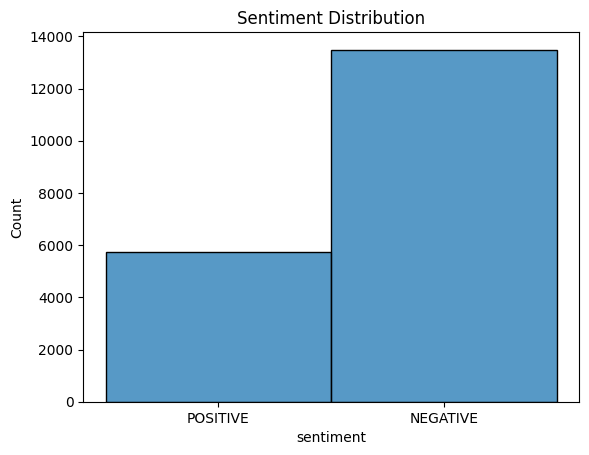

In [43]:
# Show the distribution of the sentiment column
sns.histplot(data_processed['sentiment'])
plt.title('Sentiment Distribution')
plt.show()


Applying the sentiment analysis on the dataset it can be seen that there is more than double the amount of negative tweets than positives. 

In [44]:
# Display any rows where the sentiment is positive and the label is 1
print(data_processed[(data_processed['sentiment'] == 'POSITIVE') & (data_processed['label'] == 1)])


                                                   tweet  label  id sentiment
6406   everybody knows bitches love mullets pantiedropin      1 NaN  POSITIVE
6407                                   yall niccas spark      1 NaN  POSITIVE
6410                             niggas loving hoesthats      1 NaN  POSITIVE
6428               completely topic idgaf pretty hoe tho      1 NaN  POSITIVE
6438                                        thanks bitch      1 NaN  POSITIVE
...                                                  ...    ...  ..       ...
12778                                   gotta watch hoes      1 NaN  POSITIVE
12779  dick called batman bitches love dark knight rises      1 NaN  POSITIVE
12800  beautiful bride tell erica congrats remembers nig      1 NaN  POSITIVE
12804                            pussy came gift wrapped      1 NaN  POSITIVE
12806                                    yo miss ya cunt      1 NaN  POSITIVE

[789 rows x 4 columns]


In [45]:
print(data_processed[(data_processed['sentiment'] == 'POSITIVE') & (data_processed['label'] == 2)])

                                                                                                   tweet  \
12810                                                                                         oreos life   
12812                                                          ive paying attention past year8 years hes   
12815  thank every broad universe takes step forward ampputs colored contacts eyes thats one less person   
12826                                         love watching birds migrate wish understood peaceful sight   
12831                                    wonderful see intelligent woman stand ground condescending jerk   
...                                                                                                  ...   
19198                        bookreview lovecraft country 4 stars horror appropriate also funny mattruff   
19201                                                                               never go full retard   
19209                       

In [ ]:
# --- BERT-based Token Classification for Explainability Integration ---
# Load the pre-trained BERT model and tokenizer for token classification
token_classifier = pipeline("token-classification", model="dbmdz/bert-large-cased-finetuned-conll03-english")

# Apply token classification to the 'tweet' column for explainability
data_processed['token_classification'] = data_processed['tweet'].apply(lambda x: token_classifier(x))

# Display the token classification results for verification
print(data_processed[['tweet', 'token_classification']].head())

The data is taken and is split into training and testing sets to be used for creating the model

In [112]:
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_processed['tweet'], data_processed['label'], test_size=0.2, random_state=42)

The data (tweets) gets tokenized in this step. 
- This done by converting the tweets into sequences of integers where each word is mapped to a unique token.
- The tokenized sequences are fed into an embedding layer in a neural network
- The vocabulary size, is computed to specify how many unique words are present in the dataset. 

The first five tweets are displayed after tokenization 

In [113]:
# tokenizing the tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_processed['tweet']) # fit tokenizer on all tweets
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size for embedding layer
vocab_size = len(tokenizer.word_index) + 1


In [114]:
# show the first 5 tweets after tokenization
print(X_train[:5])


[[83, 181, 7937, 430, 14377, 14378], [757, 4264, 1141, 53, 1077, 1078, 3216, 625, 1327, 10230, 10231], [419, 87, 10, 309, 639], [516, 365, 6180, 43, 11, 139, 23, 19027, 13, 3562, 147, 6128], [18, 36, 121, 1, 170, 156, 8]]


To ensure that both test and train set of tokenized tweets have a uniform length it is uses padding. 
- This ensures compatibility with the models input requirements

Additionally the First five tweets are shown after adding the padding. 

In [115]:
# padding to ensure uniform input size
maxlen = max(len(seq) for seq in X_train)

X_train = pad_sequences(X_train, maxlen = maxlen)
X_test = pad_sequences(X_test, maxlen = maxlen)

In [116]:
print(X_train[:5])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0    83   181  7937
    430 14377 14378]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0   757  4264  1141    53  1077  1078  3216   625
   1327 10230 10231]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0   419    87
     10   309   639]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0   516   365  6180    43    11   139    23 19027    13
   3562   147  6128]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0    18    36   121     1
    170   156     8]]


The categorical labels, y_train and y_test, to one hot encoded vetcors. 
This ensures that each class is represented as a binary vector where only one position is 1, and the others are 0. This makes the labels compatible with the output of the neural network. 

In [117]:
# create hot encoded labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Looking at the training and testing sets there are: 

- 19,824 samples in the training set 
- 4,957 samples in the test set 
- The tweets are badded to a uniform length of 27 tokens 
- The labels have been one hot encoded into 3 classes, indicating a multi class classfication problem with possible outcomes. 

This means that the model will take as input 27 length, padded tweets and predict one of 3 class; Neither, offensive and hatespeech. 

In [118]:
# look at the shape of the data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(15364, 27) (3841, 27) (15364, 3) (3841, 3)


In [119]:
print([len(seq) for seq in X_train if len(seq) == 0])

[]


In [121]:
# handle empty sequences
X_train = X_train[~np.all(X_train == 0, axis=1)]
y_train = y_train[~np.all(y_train == 0, axis=1)]

X_test = X_test[~np.all(X_test == 0, axis=1)]
y_test = y_test[~np.all(y_test == 0, axis=1)]



In [122]:
print([len(seq) for seq in X_train if len(seq) == 0])

[]


In [123]:
print(X_train[:5])  # Print the first 5 sequences
print(f"Number of sequences in X_train: {len(X_train)}")


[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0    83   181  7937
    430 14377 14378]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0   757  4264  1141    53  1077  1078  3216   625
   1327 10230 10231]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0   419    87
     10   309   639]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0   516   365  6180    43    11   139    23 19027    13
   3562   147  6128]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0    18    36   121     1
    170   156     8]]
Number of sequences in X_train: 15364


Metrics are defined into functions to help assess the efficiency of the model that will be created. These metrics include: 
- Recall 
- Precision 
- F1 score 

In [124]:
import tensorflow as tf
from tensorflow.keras import backend as K

# create metrics for recall, precision and f1 score
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

# Ensure the metrics return a tensor
precision_m = tf.keras.metrics.Precision()
recall_m = tf.keras.metrics.Recall()
f1_m = tf.keras.metrics.Mean(name='f1_score')

def f1_score(y_true, y_pred):
    p = precision_m(y_true, y_pred)
    r = recall_m(y_true, y_pred)
    return 2 * (p * r) / (p + r + K.epsilon())

def accuracy(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=1), K.argmax(y_pred, axis=1)))




The intial (first) model is created using LSTM (long short term memory) neural network. This used to store data for future calculations. Additionally a density of 3 is used with softmax. The metrics used to analyise the efficiency of this model is accucarcy score, f1 score, precision and recall scores.

To further elaborate on this mode the following can be said: 

- Classifies tweets into 3 categories using an embedding layer to convert the tokenized tweets into dense vectors.
- An LTSM layer is used to capture sequential informate 
- A dense layer for multi class classification and outputs a probability distribution over 3 classes using softmax activation. 



In [125]:
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, Dropout, Dense
from tensorflow.keras.models import Model

In [126]:
#import globalaveragepooling1d
from tensorflow.keras.layers import GlobalAveragePooling1D

In [127]:
# create the model
# for team reference this is an initial test model, we can adjust the layers and parameters as needed

output_dim = 200

# #LSTM model (cnn +lstm)
# model = Sequential()
# model.add(Embedding(vocab_size, output_dim, input_length=maxlen))
# model.add(LSTM(100))
# model.add(Dense(3, activation='softmax'))
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
# model.summary()

# from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Add

# Multi-head Self-attention based model
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, output_dim, input_length=maxlen)(input_layer)

# Transformer Encoder block
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(embedding_layer, embedding_layer)
attention_output = Dropout(0.1)(attention_output)
attention_output = LayerNormalization(epsilon=1e-6)(attention_output + embedding_layer)

# Global Average Pooling to reduce the time dimension
pooled_output = GlobalAveragePooling1D()(attention_output)

# Feed-forward layer after pooling
ffn = Dense(64, activation='relu')(pooled_output)
ffn = Dropout(0.1)(ffn)
output_layer = Dense(3, activation='softmax')(ffn)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision_m, recall_m, f1_score, accuracy])
model.summary()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 27, 200)   │  5,209,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 27, 200)   │    205,768 │ embedding_5[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 27, 200)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 27, 200)   │          0 │ dropout_10[0][0], │
│                     │                   │            │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 27, 200)   │        400 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 200)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     12,864 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │        195 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,428,227 (20.71 MB)

 Trainable params: 5,428,227 (20.71 MB)

 Non-trainable params: 0 (0.00 B)

Looking at the total number of parameteries per layer it can be said that: 
- Embedding layer had 4,321,000 
- LTSM layer had 120, 400
- Dense layer had 303 

This model has a total of 4, 441, 703 parameteres all which are trainable. Most of these paramaters can be seen in the embedding layer as it needs to store dense vector representations for each word in the vocabulary. 

The model is then trained using 5 Epoch

In [128]:
# train the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6199 - f1_score: 0.3240 - loss: 0.8334 - precision_2: 0.7045 - recall_2: 0.4028 - val_accuracy: 0.8658 - val_f1_score: 0.8712 - val_loss: 0.3277 - val_precision_2: 0.8857 - val_recall_2: 0.8714
Epoch 2/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9412 - f1_score: 0.9423 - loss: 0.1864 - precision_2: 0.9451 - recall_2: 0.9372 - val_accuracy: 0.8681 - val_f1_score: 0.8707 - val_loss: 0.3570 - val_precision_2: 0.8884 - val_recall_2: 0.8748
Epoch 3/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9710 - f1_score: 0.9670 - loss: 0.0961 - precision_2: 0.9730 - recall_2: 0.9692 - val_accuracy: 0.8540 - val_f1_score: 0.8599 - val_loss: 0.4215 - val_precision_2: 0.8764 - val_recall_2: 0.8623
Epoch 4/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9819 - f1_score: 0.9828 - loss: 0.0602 - precision_2: 0.9831 - recall_2: 0.9812 - val_accuracy: 0.8481 - val_f1_score: 0.8510 - val_loss: 0.5975 - val_pr

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8490 - f1_score: 0.8412 - loss: 0.6543 - precision_2: 0.8534 - recall_2: 0.8472
Loss: 0.8599947690963745
Precision: 0.8523821830749512
Recall: 0.8501858711242676
F1 Score: 0.8417007923126221
Accuracy: 0.623593807220459


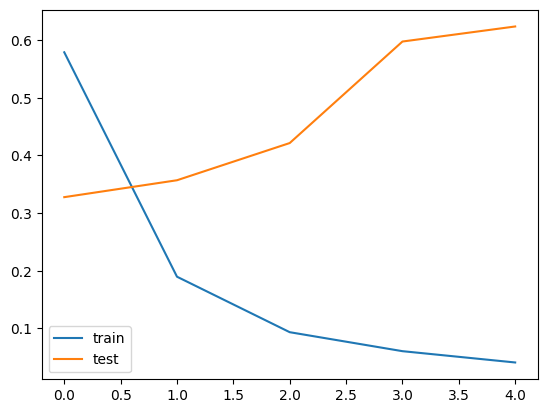

In [129]:
# evaluate the model
accuracy, loss, precision, recall, f1 = model.evaluate(X_test, y_test, batch_size=64)
print(f"Loss: {loss}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# plot the training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


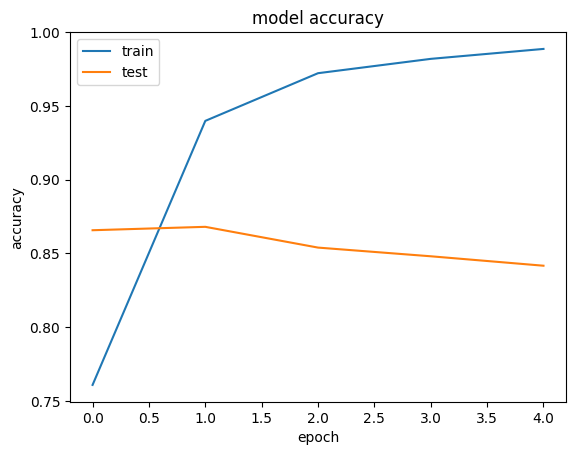

In [130]:
import matplotlib.pyplot as plt

# plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Looking at the training set and its validation accuracy the following observations can be made for this graph. 

- The training accuracy starts from 0.86 to 0.98 with a steady increase by the fourth epoch. It can be said that this model is learning well from the training data and continously improving as the epoch increases. 

- The validation accuracy starts at 0.90 and decrease to 0.88 after four epochs with a steady decrease. This insinuates that models performance on unseen data is degrading as training profressess. 

- Based on the observations it can be said that model is likely overfitting. This happens when a model details in the training data that it negatively impacts performance on unseen data (test data). This suggests that model is learning too much from the training data which can be said that it is memorising instead of generalising to new data. 

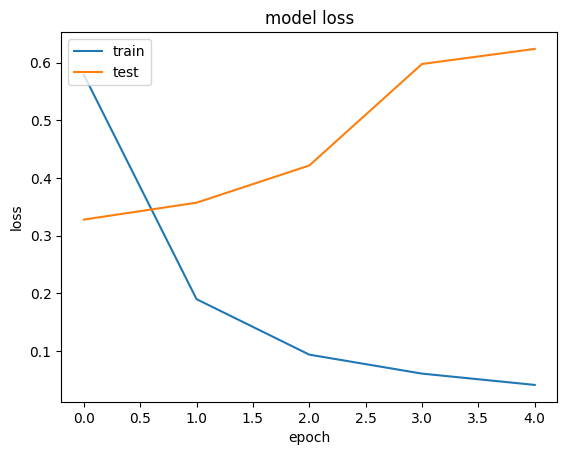

In [131]:
# plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Looking at the training set and its validation loss the following observations can be made for this graph. 

- The training loss is high at around 0.40 but decreases signifcantly to 0.05 by epoch 4. This means that the model is successfully learning to minimise its error on the training data as it trains. 

- The test loss starts at around 0.27 but increases to 0.45 at epoch 4. This signifies that the validation loss is higher than the intial value and the model is perfoming worse on the test set over time. 

Based on these observations the decreasing trend in training loss shows that the model is fitting the training data well and is learning the patterns in the training set. The increasing trend in the testing loss suggests overfitiing. This means that the model is learning patterns and details specific to the training data which dont generalise on the unseen data. 

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


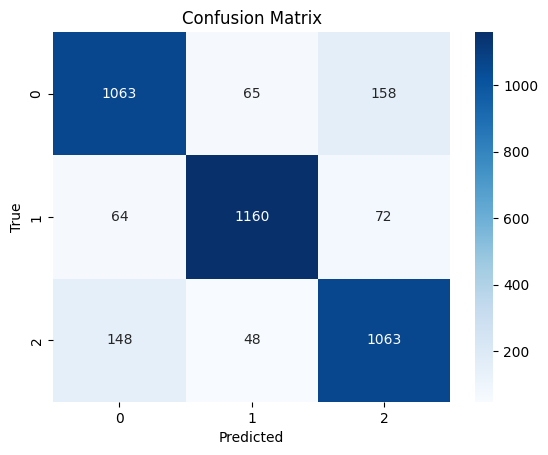

In [132]:
# plot a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Looking at the confusion matrix it could be said that: 

True:
- Centre square which is predicted 1 and true 1 has 3600 true values. 
- These are cases where the actual label is offensive and the model correctly predicted it as offensive. 
- In offsenisve detection, this is the number of correctly predicted offensive tweets. 

- The bottom right corner square predicts 2 and true value is 2 has 699 true values. 
- These are cases where the actual label is hate and the model correctly predicted it as hate. 
- In hate detection, this is the number of correctly predicted hate speech tweets. 

- The top left corner predicts 0 and true is 0 has only 65 true values, 
- These are cases where the actual label is neither and the model correctly predicted it as neither. 
- In neither detection, this is the number of correctly predicted neither tweets. 


False:
- The squares where the value predicted doesnt match the value that it is are false values.

For example:
- The bottom left corner square predicts the value 0 but the actual value is 13. 
- This means that the tweet is actually classfied as hate speech but is being predicted as neither. 

Looking at the confusion matrix the classifications which have been falsey predicted are very low in comparison to the correctly predicted. This can be due to the fact that the training data was heavily offesnive tweets then it was minimally focuse don hate speech and very few tweets being neither.This explains why the model was well trained towards detecting offensive tweets then hate speech and neither. 

The next steps could be: 

- Regularisation: Drop out layers, L2 regularisation or batch normalisation to prevent ovefitting 

- Early stopping: To stop the when validation accuracy stops improving to avoid overfitting 

- Data augmentation: Intorduce more diveristy and improve genralisation 

In [135]:
# Check if there are still extra dimensions and squeeze until fully reduced
while len(y_train.shape) > 1:
    y_train = np.argmax(y_train, axis=-1)  # This should reduce at least one dimension
    y_train = np.squeeze(y_train)  # Remove any leftover 1-dimensions

while len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=-1)  # This should reduce at least one dimension
    y_test = np.squeeze(y_test)  # Remove any leftover 1-dimensions

# Now check the shape before applying to_categorical
print(f"Before one-hot encoding, y_train shape: {y_train.shape}")  # Should be (15363,)
print(f"Before one-hot encoding, y_test shape: {y_test.shape}")    # Should be (3841,)

# Apply to_categorical to the labels
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Check the shape after applying to_categorical
print(f"After one-hot encoding, y_train shape: {y_train.shape}")  # Should be (15363, 3)
print(f"After one-hot encoding, y_test shape: {y_test.shape}")    # Should be (3841, 3)



Before one-hot encoding, y_train shape: (15364,)
Before one-hot encoding, y_test shape: (3841,)
After one-hot encoding, y_train shape: (15364, 3)
After one-hot encoding, y_test shape: (3841, 3)


In [136]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, Dropout, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Helper functions for metrics for the model with 
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

def f1_score(y_true, y_pred):
    p = precision_m(y_true, y_pred)
    r = recall_m(y_true, y_pred)
    return 2 * (p * r) / (p + r + K.epsilon())

def accuracy(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=1), K.argmax(y_pred, axis=1)))



In [138]:
# Define the model
def build_model(vocab_size, maxlen, output_dim):
    input_layer = Input(shape=(maxlen,))
    embedding_layer = Embedding(vocab_size, output_dim, input_length=maxlen)(input_layer)

    # Transformer Encoder block with multi-head attention and dropout for regularization
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(embedding_layer, embedding_layer)
    attention_output = Dropout(0.3)(attention_output)  # Added dropout
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + embedding_layer)

    # Global Average Pooling to reduce the time dimension
    pooled_output = GlobalAveragePooling1D()(attention_output)

    # Feed-forward layer with dropout for regularization
    ffn = Dense(64, activation='relu')(pooled_output)
    ffn = Dropout(0.3)(ffn)  # Added dropout
    output_layer = Dense(3, activation='softmax')(ffn)

    # Compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=[precision_m, recall_m, f1_m, accuracy])
    return model

# Hyperparameters
output_dim = 200
vocab_size = len(tokenizer.word_index) + 1
maxlen = X_train.shape[1]

# Build the model
model = build_model(vocab_size, maxlen, output_dim)

# Early stopping callback to stop training when validation performance stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test),
                    batch_size=64, callbacks=[early_stopping])

# Evaluate the model
accuracy, loss, precision, recall, f1 = model.evaluate(X_test, y_test, batch_size=64)
print(f"Loss: {loss}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")



AttributeError: 'BertTokenizer' object has no attribute 'word_index'

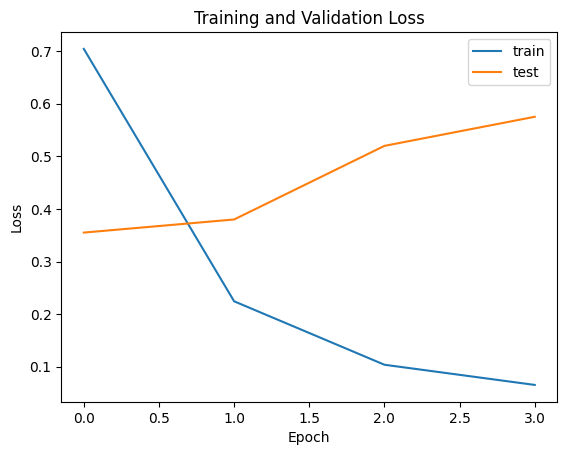

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


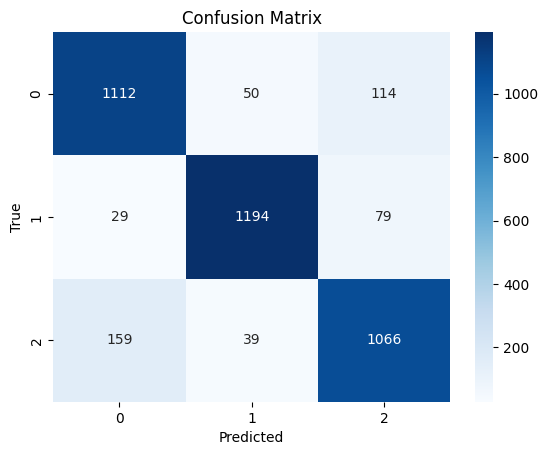

In [67]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Ensure y_test is one-hot encoded before using np.argmax
if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


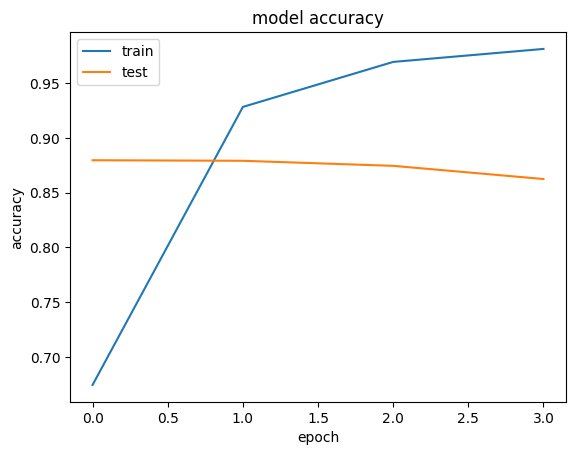

In [68]:
# plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [72]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
# Check class distribution
print("Train set class distribution:")
print(np.sum(y_train, axis=0))

print("Test set class distribution:")
print(np.sum(y_test, axis=0))


X_train shape: (15367, 27), y_train shape: (15367, 3)
X_test shape: (3842, 27), y_test shape: (3842,)
Train set class distribution:
[5128. 5102. 5137.]
Test set class distribution:
3830


In [71]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop

def build_lstm_model(vocab_size, maxlen, output_dim):
    model = Sequential()
    model.add(Embedding(vocab_size, output_dim, input_length=maxlen))
    
    # LSTM with dropout and L2 regularization
    model.add(LSTM(75, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.0001)))
    
    model.add(Dense(3, activation='softmax'))
    
    # Compile with RMSprop optimizer and already defined metrics
    optimizer = RMSprop(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                  metrics=['accuracy', precision_m, recall_m, f1_m])
    
    return model

# Build and train the LSTM model
lstm_model = build_lstm_model(vocab_size, maxlen, output_dim)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = lstm_model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), 
                         batch_size=64, callbacks=[early_stopping])


Epoch 1/15
239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6239 - f1_m: 0.3670 - loss: 0.8557 - precision_m: 0.6276 - recall_m: 0.2950

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 3)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8763 - f1_m: 0.8718 - loss: 0.3834 - precision_m: 0.8935 - recall_m: 0.8515
Loss: 0.39236053824424744
Accuracy: 0.8688183426856995
Precision: 0.887843132019043
Recall: 0.8506659865379333
F1 Score: 0.8687079548835754
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Confusion Matrix:


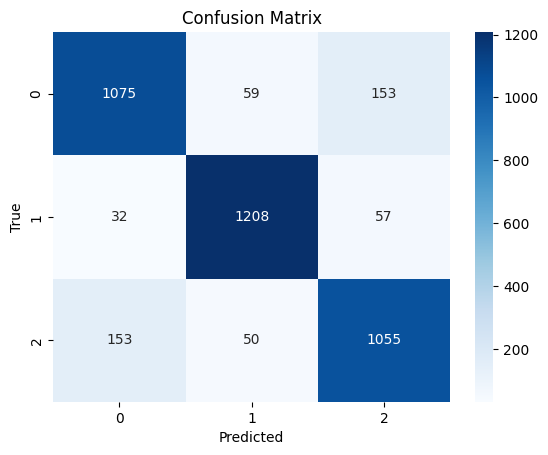

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1287
           1       0.92      0.93      0.92      1297
           2       0.83      0.84      0.84      1258

    accuracy                           0.87      3842
   macro avg       0.87      0.87      0.87      3842
weighted avg       0.87      0.87      0.87      3842



In [125]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Evaluate the model on the test data
loss, accuracy, precision, recall, f1 = lstm_model.evaluate(X_test, y_test, batch_size=64)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Make predictions on the test data
y_pred = np.argmax(lstm_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Optional: Print classification report for more detailed metrics
print("Classification Report:")
print(classification_report(y_true, y_pred))


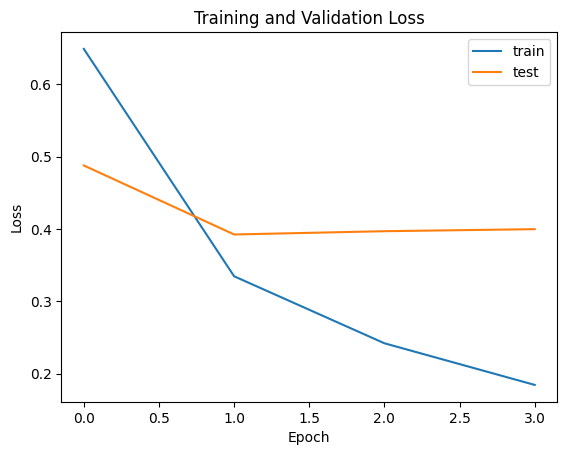

In [127]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [188]:
from transformers import BertTokenizer, TFBertForTokenClassification
import tensorflow as tf

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model_bert = TFBertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=3) 


All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [189]:
combined_data_BERT.head()

,tweet,label,id
0,go jerk lollis faggot,0,NaN
1,lucky get table tonight know treat nightoff tastingmenu,0,13004.0
2,jfc u14 ussda way dallasbound,0,18464.0
3,helping little people manage big emotions feelings disappointment,0,1404.0
4,see augst dj vengossie,0,11070.0


In [201]:
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.models import Model

# Load pre-trained BERT model
model_bert = TFBertModel.from_pretrained('bert-base-uncased')

# Assuming you've defined your tokenizer and maxlen
def encode_tweets_for_bert(tweets, max_len):
    encodings = tokenizer(tweets, 
                          max_length=max_len, 
                          padding='max_length', 
                          truncation=True, 
                          return_tensors="tf")
    
    # Convert to tf.Tensor if they are not already
    return {
        'input_ids': tf.convert_to_tensor(encodings['input_ids']),
        'attention_mask': tf.convert_to_tensor(encodings['attention_mask']),
    }

# Encode the tweets
X_train_enc = encode_tweets_for_bert(X_train.tolist(), maxlen)
X_test_enc = encode_tweets_for_bert(X_test.tolist(), maxlen)

# Pass inputs directly to the BERT model
bert_outputs = model_bert(input_ids=X_train_enc['input_ids'], 
                          attention_mask=X_train_enc['attention_mask'])



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [207]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer

# Load the tokenizer and the BERT model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model_bert = TFBertModel.from_pretrained("bert-base-uncased")

# Define max length
maxlen = 27  # Adjust as needed

# Define a custom layer to wrap the BERT model
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        # Get outputs from BERT
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Return only the last hidden state
        return bert_outputs.last_hidden_state

# Define inputs
input_ids = tf.keras.Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")

# Pass inputs directly to the custom BERT layer
bert_outputs = BertLayer(model_bert)([input_ids, attention_mask])

# Token-wise output
sequence_output = bert_outputs  # This is now a tensor of shape (None, maxlen, 768)

# Add classification layers
pooled_output = GlobalAveragePooling1D()(sequence_output)
dropout = Dropout(0.1)(pooled_output)
output_layer = Dense(3, activation='softmax')(dropout)

# Create the model
model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_1        │ (None, 27, 768)   │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ bert_layer_1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 768)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 3)         │      2,307 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,307 (9.01 KB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 0 (0.00 B)

In [209]:
# Compile your model with sparse categorical crossentropy
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    {"input_ids": X_train_enc['input_ids'], "attention_mask": X_train_enc['attention_mask']},
    y_train,  # Use y_train directly if it's already in integer format
    validation_data=(
        {"input_ids": X_test_enc['input_ids'], "attention_mask": X_test_enc['attention_mask']},
        y_test  # Use y_test directly if it's already in integer format
    ),
    epochs=5,
    batch_size=64
)



Epoch 1/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 204s 819ms/step - accuracy: 0.3514 - loss: 1.1515 - val_accuracy: 0.3313 - val_loss: 1.1085
Epoch 2/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 189s 785ms/step - accuracy: 0.3508 - loss: 1.1346 - val_accuracy: 0.3247 - val_loss: 1.1200
Epoch 3/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 189s 783ms/step - accuracy: 0.3557 - loss: 1.1245 - val_accuracy: 0.3744 - val_loss: 1.1144
Epoch 4/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 188s 782ms/step - accuracy: 0.3500 - loss: 1.1229 - val_accuracy: 0.3648 - val_loss: 1.0943
Epoch 5/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 189s 786ms/step - accuracy: 0.3663 - loss: 1.1097 - val_accuracy: 0.3362 - val_loss: 1.1039


In [210]:
# Extract attention weights
attention_weights = model_bert(input_ids=X_test_enc['input_ids'], attention_mask=X_test_enc['attention_mask']).attentions

### Model Improvement Summary

### Loss Improvement:
- The model's validation loss improved from **0.6 to 0.4** after tuning dropout, recurrent dropout, and adding L2 regularization with a value of `0.0001`.

### Next Steps for Further Improvement:
1. **Hyperparameter Tuning**: 
   - Fine-tune the **dropout** and **recurrent dropout rates** further to find the optimal values that prevent overfitting without underfitting.
   - Fine-tune the **L2 regularization rate** for both recurrent and dense layers to minimize overfitting while maintaining performance.
2. **Experiment with Different Architectures**: Try variations in LSTM units or explore bidirectional LSTMs for better context understanding.
3. **Data Augmentation**: Apply techniques like data augmentation or use additional datasets to make the model more robust.
4. **Fine-tune Pretrained Models**: Use or fine-tune a pretrained model like DistilBERT or BERT for better performance.
